# SMAP usage example

This example shows how to use SMAP to create a simple model

## Import the SMAP module

In [15]:
from mogestpy.quantity.Hydrological.SMAP2 import Smap

Loading precipitation and evapotranspiration data from a XLSX file

In [16]:
import pandas as pd
df = pd.read_excel('../../datasets/Biritiba_SMAP.xlsx')
display(df)

,ET,P
0,5.266667,0.000000
1,5.266667,0.000000
2,5.266667,0.000000
3,5.266667,0.400000
4,5.266667,4.200000
...,...,...
2118,3.233333,0.000000
2119,3.233333,0.000000
2120,3.233333,0.000000
2121,3.233333,1.086667


In [17]:
smap_biritiba = Smap(
    Str=100,
    k2t=1.43064763229058,
    Crec=19.612562479845,
    Ai=2,
    Capc=30/100,
    kkt=47.5320152819107,
    Tuin=.05,
    Ebin=0,
    Ad=70.2
)

Running the model with the dataset values

In [18]:
discharge = smap_biritiba.run_to_list(
    df['P'].values,
    df['ET'].values
)

In [19]:
df['Q'] = discharge

### Plotting the results

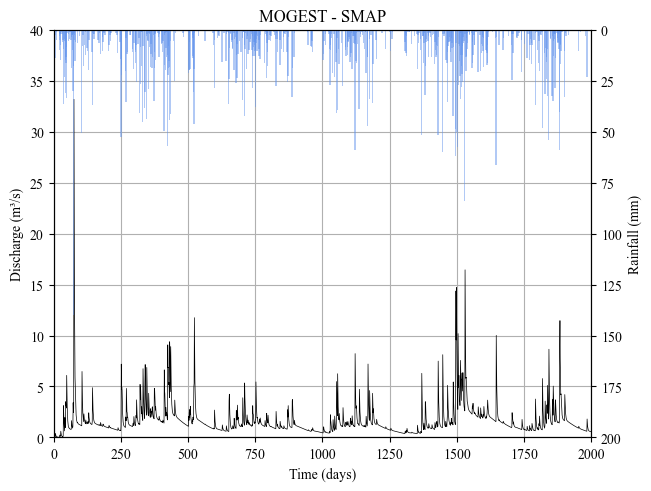

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman']

fig, ax = plt.subplots(constrained_layout=True)
ax.grid(True)

x_axis = [i for i in range(len(df))]

ax.set_xlim(0, 2000)
ax.set_ylim(0, 40)

ax.set_xlabel('Time (days)')
ax.set_ylabel('Discharge (m³/s)')

prec = ax.twinx()
prec.bar(x_axis, df['P'], color='cornflowerblue', width=5, zorder=1, alpha=.5)
prec.set_ylim(0,200)
prec.invert_yaxis()
prec.set_ylabel('Rainfall (mm)')
ax.plot(x_axis, df['Q'], color='black', linewidth=.5, zorder=2)
ax.set_title('MOGEST - SMAP')
plt.show()

The run_to_dataframe method returns a pandas dataframe with the results of the simulation.

In [22]:
df_smap = smap_biritiba.run_to_dataframe(
    df['P'].values,
    df['ET'].values
)
display(df_smap)

,prec,etp,Rsolo,Rsub,Rsup,Tu,Es,Er,Rec,Ed,Eb,discharge
0,0.000000,5.266667,4.690577,0.046090,0.000000,0.050000,0.000000,0.263333,0.046090,0.000000,0.000000,0.000000
1,0.000000,5.266667,4.403149,0.085813,0.000000,0.046906,0.000000,0.247037,0.040391,0.000000,0.000667,0.000542
2,0.000000,5.266667,4.135817,0.120004,0.000000,0.044031,0.000000,0.231899,0.035434,0.000000,0.001242,0.001009
3,0.400000,5.266667,3.903426,0.149381,0.000000,0.041358,0.000000,0.601276,0.031114,0.000000,0.001737,0.001412
4,4.200000,5.266667,3.832281,0.174805,0.049239,0.039034,0.049239,4.194320,0.027586,0.000000,0.002163,0.001757
...,...,...,...,...,...,...,...,...,...,...,...,...
2118,0.000000,3.233333,17.201900,33.323119,0.111749,0.184558,0.000000,0.596738,0.657179,0.069660,0.479849,0.446476
2119,0.000000,3.233333,16.075480,33.410928,0.068838,0.172019,0.000000,0.556195,0.570225,0.042911,0.482416,0.426828
2120,0.000000,3.233333,15.058335,33.424612,0.042405,0.160755,0.000000,0.519774,0.497372,0.026433,0.483688,0.414473
2121,1.086667,3.233333,14.299221,33.376588,0.026121,0.150583,0.000000,1.409919,0.435862,0.016283,0.483886,0.406387
